In [1]:
## Layoff Analysis

In [2]:
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style("darkgrid")

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/layoffs-2022/layoffs.csv


In [4]:
df = pd.read_csv('/kaggle/input/layoffs-2022/layoffs.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2232 entries, 0 to 2231
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              2232 non-null   object 
 1   location             2232 non-null   object 
 2   industry             2231 non-null   object 
 3   total_laid_off       1534 non-null   float64
 4   percentage_laid_off  1503 non-null   float64
 5   date                 2232 non-null   object 
 6   stage                2226 non-null   object 
 7   country              2232 non-null   object 
 8   funds_raised         2037 non-null   float64
dtypes: float64(3), object(6)
memory usage: 157.1+ KB


In [5]:
df.head()

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised
0,Twilio,SF Bay Area,Other,1500.0,0.17,2023-02-13,Post-IPO,United States,614.0
1,Casavo,Milan,Real Estate,NaN,0.30,2023-02-13,Unknown,Italy,708.0
2,Getir,London,Food,NaN,NaN,2023-02-13,Series E,United Kingdom,1800.0
3,LinkedIn,SF Bay Area,HR,NaN,NaN,2023-02-13,Acquired,United States,154.0
4,Moladin,Jakarta,Transportation,360.0,0.11,2023-02-12,Series B,Indonesia,138.0


In [6]:
# top 10 countries which the layoffs companies in
df.country.value_counts()[:10]

United States     1460
India              140
Canada              99
United Kingdom      72
Brazil              70
Germany             65
Israel              52
Australia           47
Singapore           32
Indonesia           24
Name: country, dtype: int64

In [7]:
# keep only companies in US
df = df[df.country == 'United States']
df.shape

(1460, 9)

In [8]:
# check NaN values
df.isnull().sum()

company                  0
location                 0
industry                 1
total_laid_off         486
percentage_laid_off    477
date                     0
stage                    4
country                  0
funds_raised           108
dtype: int64

In [9]:
# drop rows missing industry and stage data
df = df[df.industry.notna() & df.stage.notna()]
df.shape

(1455, 9)

### Which industries are the hardest hit by layoffs?

In [10]:
df.industry.nunique()

29

<AxesSubplot:xlabel='total_laid_off', ylabel='industry'>

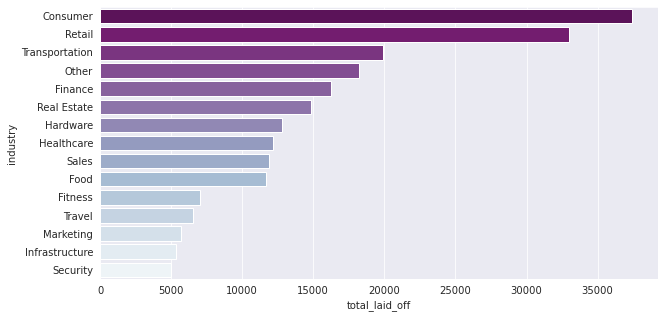

In [11]:
plt.figure(figsize=(10,5))
indsSum = df[['industry', 'total_laid_off']] \
            .groupby('industry', as_index=False).sum() \
            .sort_values(by='total_laid_off', ascending=False)
sns.barplot(data=indsSum.iloc[:15], x='total_laid_off', y='industry', palette='BuPu_r')

<AxesSubplot:xlabel='company', ylabel='industry'>

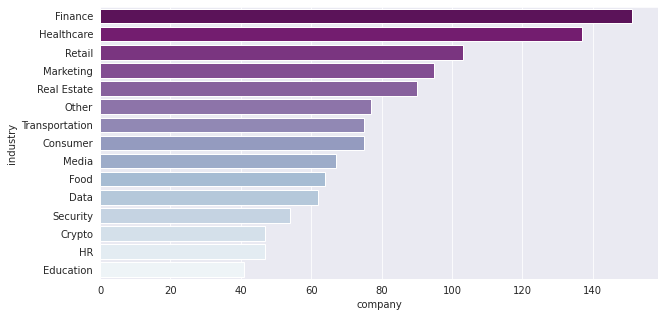

In [12]:
plt.figure(figsize=(10,5))
indsCount = df[['industry', 'company']] \
            .groupby('industry', as_index=False).count() \
            .sort_values(by='company', ascending=False)
sns.barplot(data=indsCount.iloc[:15], x='company', y='industry', palette='BuPu_r')

In [13]:
[i for i in indsSum.industry[:15] if i in indsCount.industry[:15].tolist()]

['Consumer',
 'Retail',
 'Transportation',
 'Other',
 'Finance',
 'Real Estate',
 'Healthcare',
 'Food',
 'Marketing',
 'Security']

Text(0.5, 1.0, 'Layoff Company Counts by Industry')

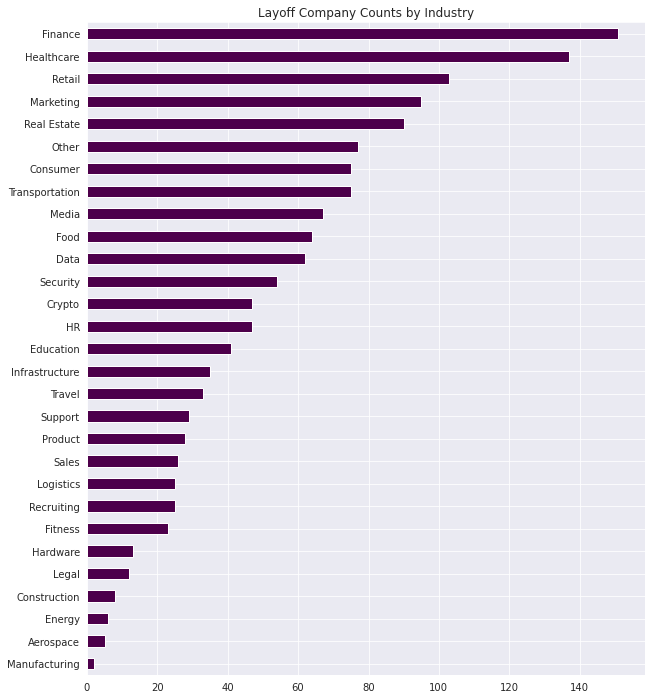

In [14]:
plt.figure(figsize=(10,12))
df.industry.value_counts().plot.barh(colormap='BuPu_r')
plt.gca().invert_yaxis()
plt.title('Layoff Company Counts by Industry')

In [15]:
df.columns

Index(['company', 'location', 'industry', 'total_laid_off',
       'percentage_laid_off', 'date', 'stage', 'country', 'funds_raised'],
      dtype='object')

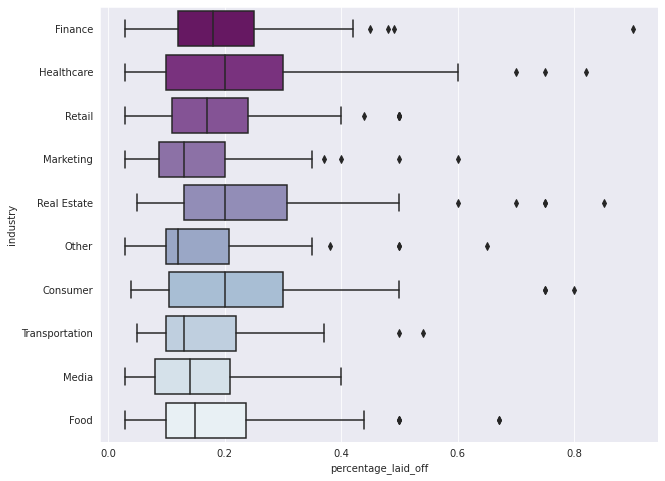

In [16]:
top10inds = df.industry.value_counts().index[:10]

q_low = df["percentage_laid_off"].quantile(0.01)
q_hi  = df["percentage_laid_off"].quantile(0.99)
df_filtered = df[(df["percentage_laid_off"] < q_hi) & (df["percentage_laid_off"] > q_low)]

plt.figure(figsize=(10,8))
ax = sns.boxplot(x="percentage_laid_off", y="industry", data=df_filtered, order=top10inds, palette='BuPu_r')

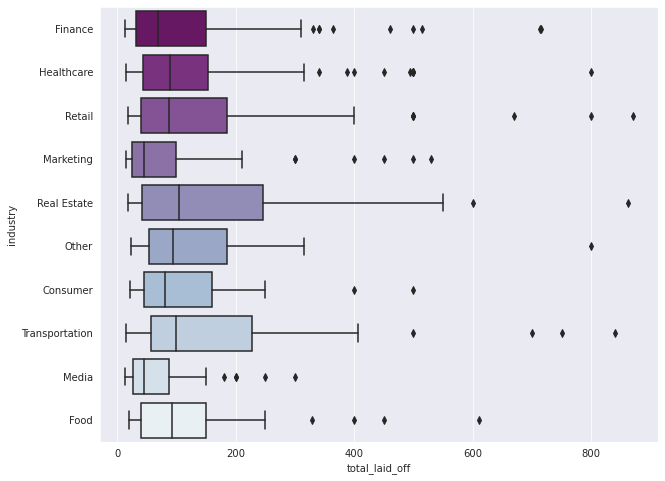

In [17]:
q_low = df["total_laid_off"].quantile(0.05)
q_hi  = df["total_laid_off"].quantile(0.95)
df_filtered = df[(df["total_laid_off"] < q_hi) & (df["total_laid_off"] > q_low)]

plt.figure(figsize=(10,8))
ax = sns.boxplot(x="total_laid_off", y="industry", data=df_filtered, order=top10inds, palette='BuPu_r')

### What is the financing status of companies with a high percentage of layoffs?

In [18]:
df["percentage_laid_off"].quantile(0.25), df["percentage_laid_off"].quantile(0.75)

(0.1, 0.3)

In [19]:
hRateCompn = df[df.percentage_laid_off >= 0.3]
hRateCompn.stage.value_counts()

Series B          58
Unknown           38
Series C          31
Series A          30
Post-IPO          21
Seed              18
Series D          17
Acquired          14
Series E          12
Series F           4
Private Equity     3
Series H           2
Series G           1
Name: stage, dtype: int64

### In which regions are the companies with high layoff ratios located?

In [20]:
hRateCompn.location.value_counts()[:10]

SF Bay Area        99
New York City      45
Los Angeles        20
Boston             19
Seattle            12
Austin              6
Chicago             4
Portland            4
Washington D.C.     3
Columbus            3
Name: location, dtype: int64

### What are the future trends of the layoff wave?

### Has the wave of layoffs reached or passed its peak?